In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as sts
import scipy
import math
import itertools
from scipy.special import zeta, kolmogorov
from math import pi, sin, cos, sqrt, exp, log
from mpl_toolkits.mplot3d import Axes3D
import sympy as sym
import seaborn as sns
from itertools import chain, combinations
from sklearn.model_selection import train_test_split as tr
import scipy.optimize as opt

In [ ]:
df = pd.read_table('/content/IB_statistics_data_HW2.4.txt',sep='\s+', engine='python')

In [ ]:
n = 230

### Задача 1.

- (a) Будем использовать обобщенный МНК.

Для начала построим ковариацинноую матрицу из условия. Как можно заметить, все ее строки (столбцы) линейно независимы.

In [ ]:
Vn = np.ones((n, n)) + np.diag(np.ones((n)))

Тогда согласно 5 слайду 17 лекции построим оценку параметра $\beta$ в следующем виде: $\hat{\beta} = (\mathbb{X}^TV_n\mathbb{X})^{-1}\mathbb{X}^TV_n^{-1}\mathbb{Y}$.

In [ ]:
X = df.loc[:, 'Ex1a.x1': 'Ex1a.x3'].to_numpy()
y = df['Ex1a.y'].to_numpy()
X = np.array(np.concatenate(([np.ones(n)], X.T), axis=0)).T
beta = np.linalg.inv(X.T @ Vn @ X) @ X.T @ np.linalg.inv(Vn) @ y
print('Оценка параметра beta, построенная по обобщенному МНК, равна', beta)

Оценка параметра beta, построенная по обобщенному МНК, равна [-0.17477664 -0.94407061  1.96011558  3.00038432]


- (b) Будем использовать модификацию обобщенного МНК. Для этого вместо обратной матрицы $V_n^{-1}$ будем искать псевдообратную матрицу Мура-Пенроуза $V_n^+ = Q\Sigma^{-1}P^T$, где $Q$ -- матрица столбцов сингулярных векторов матрицы $V_n$, $P$ -- матрица столбцов сингулярных векторов $V_n^T$, $\Sigma$ --диагональная матрица с сингулярными числами матрицы $V_n$ (по теореме о сингулярном разложении). Тогда $\tilde{\beta} = (\mathbb{X}^TV_n\mathbb{X})^{-1}\mathbb{X}^T(Q\Sigma^{-1}P^T)\mathbb{Y}$.

In [ ]:
Vn[-1] *= 2
Vn.T[-1] *= 2
Vn[-1][-2] = Vn.T[-1][-2] = 4
Vn

array([[2., 1., 1., ..., 1., 1., 2.],
       [1., 2., 1., ..., 1., 1., 2.],
       [1., 1., 2., ..., 1., 1., 2.],
       ...,
       [1., 1., 1., ..., 2., 1., 2.],
       [1., 1., 1., ..., 1., 2., 4.],
       [2., 2., 2., ..., 2., 4., 8.]])

In [ ]:
Vn_plus = np.linalg.pinv(Vn)

Проверим, дейстивтельно ли $V_n^+$ удовлетворяет равенству $V_nV_n^+V_n = V_n$.

In [ ]:
Vn @ Vn_plus @ Vn

array([[2., 1., 1., ..., 1., 1., 2.],
       [1., 2., 1., ..., 1., 1., 2.],
       [1., 1., 2., ..., 1., 1., 2.],
       ...,
       [1., 1., 1., ..., 2., 1., 2.],
       [1., 1., 1., ..., 1., 2., 4.],
       [2., 2., 2., ..., 2., 4., 8.]])

Как видим, псевдообраная матрица Мура-Пенроуза удовлетворяет данным условиям. Поэтому будем использовать $V_n^+$ в модификации обобщенного МНК.

In [ ]:
X = df.loc[:, 'Ex1b.x1': 'Ex1b.x3'].to_numpy()
y = df['Ex1b.y'].to_numpy()
X = np.array(np.concatenate(([np.ones(n)], X.T), axis=0)).T
beta = np.linalg.inv(X.T @ Vn @ X) @ X.T @ Vn_plus @ y
print('Оценка параметра beta, построенная по обобщенному МНК, равна', beta)

Оценка параметра beta, построенная по обобщенному МНК, равна [ 0.03869847  0.9460582  -1.94149032  3.05342636]


### Задача 2.

- (a) Проверим гипотезу о наличии автокорреляции. Для начала построим оценку параметра $\beta$ с помощью МНК.

In [ ]:
X = df.loc[:, 'Ex2.x1': 'Ex2.x4'].to_numpy()
y = df['Ex2.y'].to_numpy()
X = np.array(np.concatenate(([np.ones(n)], X.T), axis=0)).T
beta = np.linalg.inv(X.T @ X) @ X.T @ y
print('Оценка параметра beta, построенная по МНК, равна', beta)

Оценка параметра beta, построенная по МНК, равна [ 1.81752872e+00  6.99869210e+00  4.55513784e-02  2.36610491e-03
 -2.21359292e-02]


Найдем ошибки.

In [ ]:
eps = y - X @ beta

Теперь применим критерий Дарбина-Уотсона для проверки гипотезы об автокорреляции. Рассчитаем его статистику.

In [ ]:
from statsmodels.stats.stattools import durbin_watson
T = durbin_watson(eps)
print('Статистика критерия Дарбина-Уотсона равна', T)

Статистика критерия Дарбина-Уотсона равна 2.9826777327774727


Смоделируем функцию распределения статистики Дарбина-Уотсона для роверки гипотезы и вычисления p-value.

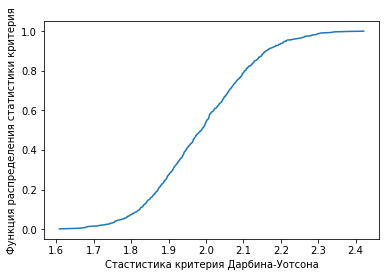

In [ ]:
sample = [sts.norm.rvs(size = n) for k in range(4*n)]
DW = [durbin_watson(s) for s in sample]

Fn = np.ones(4*n)
DW.sort()

for i in range(4*n):
  j = 0
  while(DW[j] < DW[i]):
    Fn[i] += 1
    j += 1
  Fn[i] /= 4*n

fig = plt.figure()
plt.xlabel('Стастистика критерия Дарбина-Уотсона')
plt.ylabel('Функция распределения статистики критерия')
plt.plot(np.array(DW), Fn)
plt.show()

In [ ]:
# уровень значимости
alpha = 0.05

# квантили распределения статистики критерия
dl, du = DW[min(np.where(Fn == alpha / 2))[0]], DW[min(np.where(Fn == 1 - alpha / 2))[0]]

# проверим гипотезу H0 об отсутствии автокорреляции
if T < dl:
  print('H0 отвергается против гипотезы о положительной корреляции с уровнем значимости 0.05')
if dl < T < du or 4 - du < T < 4 - dl:
  print('H0 не отвергается, и альтернатива не отвергается с уровнем значимости 0.05')
if du < T < 4 - du:
  print('H0 согласуется с выборкой с уровнем значимости 0.05')
if 4 - dl < T < 4:
  print('H0 отвергается против гипотезы об отрицательной корреляции с уровнем значимости 0.05')

# вычислим p-значение
pvalue = 1 - Fn[max(max((np.where(Fn < T))))]
print('p-value равно', pvalue)

H0 отвергается против гипотезы об отрицательной корреляции с уровнем значимости 0.05
p-value равно 1.0


- (b) ***Если гипотеза об отсутствии автокорреляции отвергается, постройте оценки всех неизвестных параметров (в том числе и коэффициента автокорреляции)***.

Так как в предыдущем пункте нулевая гипотеза отклонилась в пользу наличия автокорреляции, построим оценки параметров согласно 8 слайду лекции 17. Посторим МНК оценку исходной модели.

In [ ]:
X = df.loc[:, 'Ex2.x1': 'Ex2.x4'].to_numpy()
y = df['Ex2.y'].to_numpy()
X = np.array(np.concatenate(([np.ones(n)], X.T), axis=0)).T
beta = np.linalg.inv(X.T @ X) @ X.T @ y
beta

array([ 1.81752872e+00,  6.99869210e+00,  4.55513784e-02,  2.36610491e-03,
       -2.21359292e-02])

Далее зададим точность и будем итеративно осуществлять поиск ОМНК оценки для модели с автокорреляцией.

In [ ]:
epsilon = 0.00001
newbeta = np.ones(len(beta))
beta1 = np.array(beta)

# пока разница между старым и новым решением не станет меньше заданного эасилон
while (abs(beta1 - newbeta) > epsilon).any():
  # вычисляем ошибки, коэффициент корреляции и сумму квадратов ошибок
  er = y - X @ beta1
  s1, s2 = sum(er ** 2) - er[0] ** 2, sum([er[i - 1] * er[i] for i in range(1, n)])
  r, sigma = s2 / s1, sum(er ** 2) / n
  V = np.ones((n, n))

  # заполняем новую ковариационную матрицу
  for i in range(n):
    for j in range(n):
      V[i][j] = r ** abs(i - j)
  V *= sigma / (1 - r ** 2)

  # пересчитываем значение beta
  beta1 = newbeta
  newbeta = np.linalg.inv(X.T @ V @ X) @ X.T @ np.linalg.inv(V) @ y

print('Изначальная оценка beta:', beta, '\nНовая оценка beta:', newbeta)
print('Оценка sigma^2:', sigma, ', оценка r:', r)

Изначальная оценка beta: [ 1.81752872e+00  6.99869210e+00  4.55513784e-02  2.36610491e-03
 -2.21359292e-02] 
Новая оценка beta: [ 5.84930590e-04  2.30128364e-03 -3.07087595e-05  1.59209965e-06
 -7.43334382e-06]
Оценка sigma^2: 54.08821979129832 , оценка r: 0.11075036905219494


- (c) ***воспользуйтесь моделированием, чтобы приблизительно найти функцию распределения статистики критерия Дарбина–Уотсона в случае отсутствия
автокорреляции при m = 6 и объеме выборки 111***

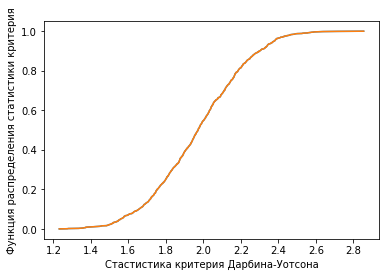

In [ ]:
N = 111
m = 6
beta = np.array([0.06, 0.7, -1, 0.05, 3, -1])
DW = []
Fn = np.ones(n * 5)

for i in range(n * 5):
    mean = np.zeros(m)
    cov = np.diag(np.ones(m))

    # выборка из многомерного нормального распределения размером N = 111
    # число измерений равно m = 6
    x = sts.multivariate_normal.rvs(mean=mean, cov=cov, size=N)

    scale = np.linspace(0.01, 1, N)
    # нормально распределенные ошибки, независимые с X
    er = sts.norm.rvs(loc=0, scale=scale, size=N)

    y = er + x @ beta
    V = np.diag(scale)
    beta = np.linalg.inv(x.T @ np.linalg.inv(V) @ x) @ x.T @ np.linalg.inv(V) @ y
    DW.append(durbin_watson(y - x @ beta))

DW.sort()

for i in range(n * 5):
    j = 0
    while(DW[j] < DW[i]):
      Fn[i] += 1
      j += 1
    Fn[i] /= n * 5

plt.plot(DW, Fn)
plt.xlabel('Стастистика критерия Дарбина-Уотсона')
plt.ylabel('Функция распределения статистики критерия')
plt.plot(np.array(DW), Fn)
plt.show()

### Задача 3.

In [ ]:
X = df.loc[:, 'Ex3x1':'Ex3x3'].to_numpy()
y = df['Ex3y'].to_numpy()
X = np.array(np.concatenate(([np.ones(n)], X.T), axis=0)).T

- ковариационная матрица ошибок имеет вид $\sigma^2\mathbb{I}$.

Оценки параметров $\sigma^2$ и $\beta$ будем строить, находясь  в стандартной модели линейной регрессии.

In [ ]:
beta = np.linalg.inv(X.T @ X) @ X.T @ y
print(beta)
eps = (y - X @ beta) ** 2
k = len(y) - len(X.T) - 1
sigma = sum(eps) / k
print('Среднее значение ошибок', sum(y - X @ beta) / n)
print(f'Оценка для параметра beta равна', beta, '\nОценка для параметра sigma^2 равна', sigma)

[-1.84920374  0.994881   -0.01320391 -3.00187785]
Среднее значение ошибок 2.7745921502371304e-15
Оценка для параметра beta равна [-1.84920374  0.994881   -0.01320391 -3.00187785] 
Оценка для параметра sigma^2 равна 1.125850682713854


- ковариационная матрица ошибок имеет вид $
\sigma^2\begin{pmatrix}
w_1 & 0 & ... & 0\\
0 & w_2 & ... & 0\\
\vdots &  & \ddots & \vdots \\
0 & ... & 0 & w_n
\end{pmatrix}, w_i = 1 + \frac{i}{n}$.

Чтобы построить оценки параметров, разделим $i$-ое уравнение на $w_i$ и затем перейдем к стандартной модели линейной регрессии.

In [ ]:
w = np.array([1 + i / n for i in range(1, n+1)])
y /= w

def transformx(x, v):
  for i in range(len(x.T)):
      x.T[i] /= v

transformx(X, w)

beta = np.linalg.inv(X.T @ X) @ X.T @ y
eps = (y - X @ beta) ** 2
k = len(y) - len(X.T) - 1
sigma = sum(eps) / k 
print('Среднее значение ошибок', sum(y - X @ beta) / n)
print(f'Оценка для параметра beta равна', beta, '\nОценка для параметра sigma^2 равна', sigma)

Среднее значение ошибок -0.012954659361580134
Оценка для параметра beta равна [-1.72362879  0.99066182 -0.0382392  -2.99601995] 
Оценка для параметра sigma^2 равна 0.6812549557133161


 - дисперсии ошибок в первых $\frac{n}{3}$ наблюдениях равны $\sigma^2_1$, в наблюдениях с номерами $\frac{n}{3} + 1, ..., \frac{2n}{3}$ равны $\sigma^2_2$, а в оставшихся наблюдениях равны $\sigma^2_3$.

Разделим выборку на 3 части. Оценим отдельно параметры, преобразуем переменные и вернемся в обычную модель.

In [ ]:
n1 = int(np.ceil(n / 3))
n2 = int(np.ceil( 2 * n / 3))
n3 = n

beta = lambda x, Y : np.linalg.inv(x.T @ x) @ x.T @ Y
sigma = lambda x, Y, beta: sum((Y - x @ beta) ** 2) /  (len(Y) - len(x.T) - 1)

x1, y1 = X[range(0, n1)], y[range(0, n1)]
x2, y2 = X[range(n1, n2)], y[range(n1, n2)]
x3, y3 = X[range(n2, n3)], y[range(n2, n3)]

beta1, beta2, beta3 = beta(x1, y1), beta(x2, y2), beta(x3, y3)
sigma1, sigma2, sigma3 = sigma(x1, y1, beta1), sigma(x2, y2, beta2), sigma(x3, y3, beta3)

print('Оценки параметров betai', beta1, '\n', beta2, '\n', beta3)
print('Оценки параметров sigmai', sigma1, sigma2, sigma3)

y1 /= sigma1
y2 /= sigma2
y3 /= sigma3

transformx(x1, sigma1)
transformx(x2, sigma2)
transformx(x3, sigma3)

x1 = np.concatenate((x1, x2, x3))
y1 = np.concatenate((y1, y2, y3))

beta4 = beta(x1, y1)
sigma4 = sigma(x1, y1, beta4)
print('Среднее значение ошибок', sum(y1 - x1 @ beta4) / n)
print(f'Оценка для параметра beta равна', beta4, '\nОценка для параметра sigma^2 равна', sigma4)

Оценки параметров betai [-1.3295162   0.97672854 -0.08255008 -3.00334037] 
 [-2.20539075  1.01353994  0.02986393 -3.00234969] 
 [-1.74401377  0.995083    0.03231723 -3.10241636]
Оценки параметров sigmai 2.050032600799991 0.331436252293018 0.997229852222812
Среднее значение ошибок 0.02628142412623265
Оценка для параметра beta равна [-2.16277711  1.01195416  0.02646722 -3.00715433] 
Оценка для параметра sigma^2 равна 1.4592975931966148


- дисперсия ошибки пропорциональна третьему признаку.

Поделим каждую строку в матрице данных на третий признак и затем вернемся к стандартной модели линейной регрессии.

In [ ]:
y /= X.T[3]

def transformx(x, v):
  for i in range(len(x.T)):
      x.T[i] /= v

transformx(X, X.T[3])

beta = np.linalg.inv(X.T @ X) @ X.T @ y
print('Среднее значение ошибок', sum(y - X @ beta) / n)
eps = (y - X @ beta) ** 2
k = len(y) - len(X.T) - 1
sigma = sum(eps) / k 
cov1 = np.diag(np.ones(n) * sigma)
print(f'Оценка для параметра beta равна', beta, '\nОценка для параметра sigma^2 равна', sigma)

Среднее значение ошибок -3.5628504977209915e-14
Оценка для параметра beta равна [-0.95032419  0.87160967  0.03554074 -2.74847228] 
Оценка для параметра sigma^2 равна 2.714695949404812


Сравним средние значения ошибок для каждой модели. Как видно из результатов выше, наименьшие средние значения наблюдаются у моделей 1 и 4. Эти две модели лучше всего описывают данные. В то время как модель 3 описывает хуже всего, так как у нее самое большое среднее значение ошибок.

### Задача 4.

In [ ]:
X = df.loc[:, 'Ex4x1':'Ex4x2'].to_numpy()
y = df['Ex4y'].to_numpy()
X = np.array(np.concatenate(([np.ones(n)], X.T), axis=0)).T

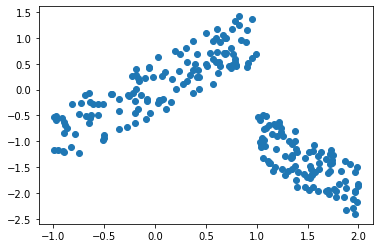

In [ ]:
plt.scatter(X.T[1], X.T[2])

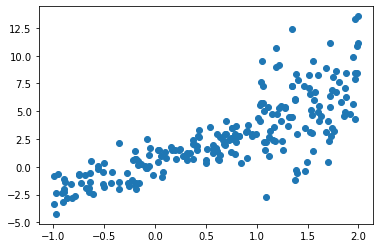

In [ ]:
plt.scatter(X.T[1], y)

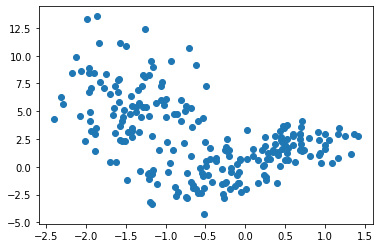

In [ ]:
plt.scatter(X.T[2], y)

Судя по данным, можно их разделить на два интервала следующим образом.

In [ ]:
X1 = X[np.where(X.T[1] > 1)]
X2 = X[np.where(X.T[1] <= 1)]

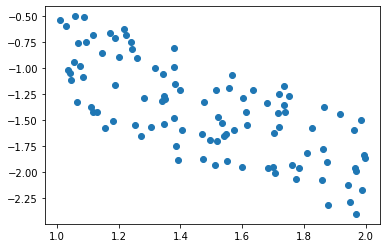

In [ ]:
plt.scatter(X1.T[1], X1.T[2])

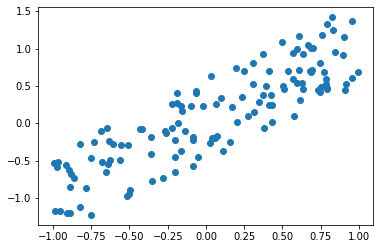

In [ ]:
plt.scatter(X2.T[1], X2.T[2])

In [ ]:
y1 = y[np.where(X.T[1] > 1)]
y2 = y[np.where(X.T[1] <= 1)]

Применим критерий Бартлетта

In [ ]:
beta1 = np.linalg.inv(X1.T @ X1) @ X1.T @ y1
s1 = np.sum((y1 - X1 @ beta1) ** 2) / n
beta2 = np.linalg.inv(X2.T @ X2) @ X2.T @ y2
s2 = np.sum((y2 - X2 @ beta2) ** 2) / n

err1 = y1 - X1 @ beta1
err2 = y2 - X2 @ beta2

sts.bartlett(err1, err2)

BartlettResult(statistic=127.39775632049803, pvalue=1.5203492346363832e-29)

Поскольку p-значение критерия Бартлетта меньше $\alpha = 0.05$, то есть основания отклонить $H_0$ о гомоскедастичности выборки